# 验证性能

In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras import backend as K

# 设置模型和测试数据路径
model_paths = [
    './Models/SP480.h5',
    './Models/Add/SP480_10.h5',
    './Models/Add/SP480_20.h5',
    './Models/Add/SP480_30.h5',
    './Models/Add/SP480_40.h5',
    './Models/Add/SP480_50.h5'
]

test_data_folders = [
    './testData/1',
    './testData/2',
    './testData/3',
    './testData/4'
]

time_steps = 12
pred_steps = 12

# 存放结果的数组
results = np.zeros((6, 4, 3))  # 6个模型，每个模型在4个测试集上，每组测试返回3个指标
average_results = np.zeros((6, 3))  # 每个模型在4个数据集上的平均MSE, MAE, SSIM

# 测试函数
def test_model(model, test_folder):
    test_images = []
    image_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.png')])
    for file in image_files:
        img = cv2.imread(os.path.join(test_folder, file), cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (480, 480), interpolation=cv2.INTER_AREA)
        normalized_img = resized_img / 255.0
        test_images.append(normalized_img)
    
    test_images = np.array(test_images)[..., np.newaxis]
    X_test = np.array([test_images[i:i + time_steps] for i in range(len(test_images) - time_steps - pred_steps + 1)])
    y_actual = np.array([test_images[i + time_steps:i + time_steps + pred_steps] for i in range(len(test_images) - time_steps - pred_steps + 1)])
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_actual.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_actual.flatten(), y_pred.flatten())
    
    ssim_scores = []
    for i in range(pred_steps):
        ssim_score = ssim(y_actual[0, i, :, :, 0], y_pred[0, i, :, :, 0], data_range=1.0)
        ssim_scores.append(ssim_score)
    mean_ssim = np.mean(ssim_scores)
    
    return mse, mae, mean_ssim

# 测试每个模型
for model_idx, model_path in enumerate(model_paths):
    print(f"正在测试模型：{model_path}")
    model = load_model(model_path)
    
    for test_idx, test_folder in enumerate(test_data_folders):
        mse, mae, mean_ssim = test_model(model, test_folder)
        results[model_idx, test_idx] = [mse, mae, mean_ssim]
        print(f"模型 {model_idx+1}, 测试集 {test_idx+1}: MSE = {mse}, MAE = {mae}, SSIM = {mean_ssim}")

    # 测试完一个模型后，清理计算图和显存
    del model  # 删除模型
    K.clear_session()  # 清理TensorFlow会话
    tf.compat.v1.reset_default_graph()  # 重置默认图

# 计算每个模型的平均性能
for model_idx in range(len(model_paths)):
    average_results[model_idx] = np.mean(results[model_idx], axis=0)
    print(f"模型 {model_idx+1} 的平均结果: MSE = {average_results[model_idx, 0]}, MAE = {average_results[model_idx, 1]}, SSIM = {average_results[model_idx, 2]}")
    
# 输出所有结果
print("\n详细结果 (每个模型在每个测试集上的 MSE, MAE, SSIM):")
for model_idx in range(len(model_paths)):
    for test_idx in range(len(test_data_folders)):
        mse, mae, ssim_val = results[model_idx, test_idx]
        print(f"模型 {model_idx+1}, 测试集 {test_idx+1}: MSE = {mse}, MAE = {mae}, SSIM = {ssim_val}")

print("\n平均结果 (每个模型在所有测试集上的平均 MSE, MAE, SSIM):")
for model_idx in range(len(model_paths)):
    print(f"模型 {model_idx+1} 的平均 MSE = {average_results[model_idx, 0]}, 平均 MAE = {average_results[model_idx, 1]}, 平均 SSIM = {average_results[model_idx, 2]}")


正在测试模型：./Models/SP480.h5
1/1 [==============================] - 0s 403ms/step
模型 1, 测试集 1: MSE = 0.01556169262405484, MAE = 0.0814339419905311, SSIM = 0.03162321798407042
1/1 [==============================] - 0s 37ms/step
模型 1, 测试集 2: MSE = 0.038752815603970106, MAE = 0.12278672364616502, SSIM = 0.031039506369888368
1/1 [==============================] - 0s 29ms/step
模型 1, 测试集 3: MSE = 0.04253628354984319, MAE = 0.13007446459988328, SSIM = 0.030786208758726678
1/1 [==============================] - 0s 37ms/step
模型 1, 测试集 4: MSE = 0.009744937778967764, MAE = 0.06932376765835033, SSIM = 0.030958828540259314
正在测试模型：./Models/Add/SP480_10.h5
1/1 [==============================] - 0s 206ms/step
模型 2, 测试集 1: MSE = 0.012632143863618163, MAE = 0.043570533887651856, SSIM = 0.2952739589652606
1/1 [==============================] - 0s 51ms/step
模型 2, 测试集 2: MSE = 0.03529010917136571, MAE = 0.08937797680048212, SSIM = 0.2304562791514998
1/1 [==============================] - 0s 41ms/step
模型 2, 测试集

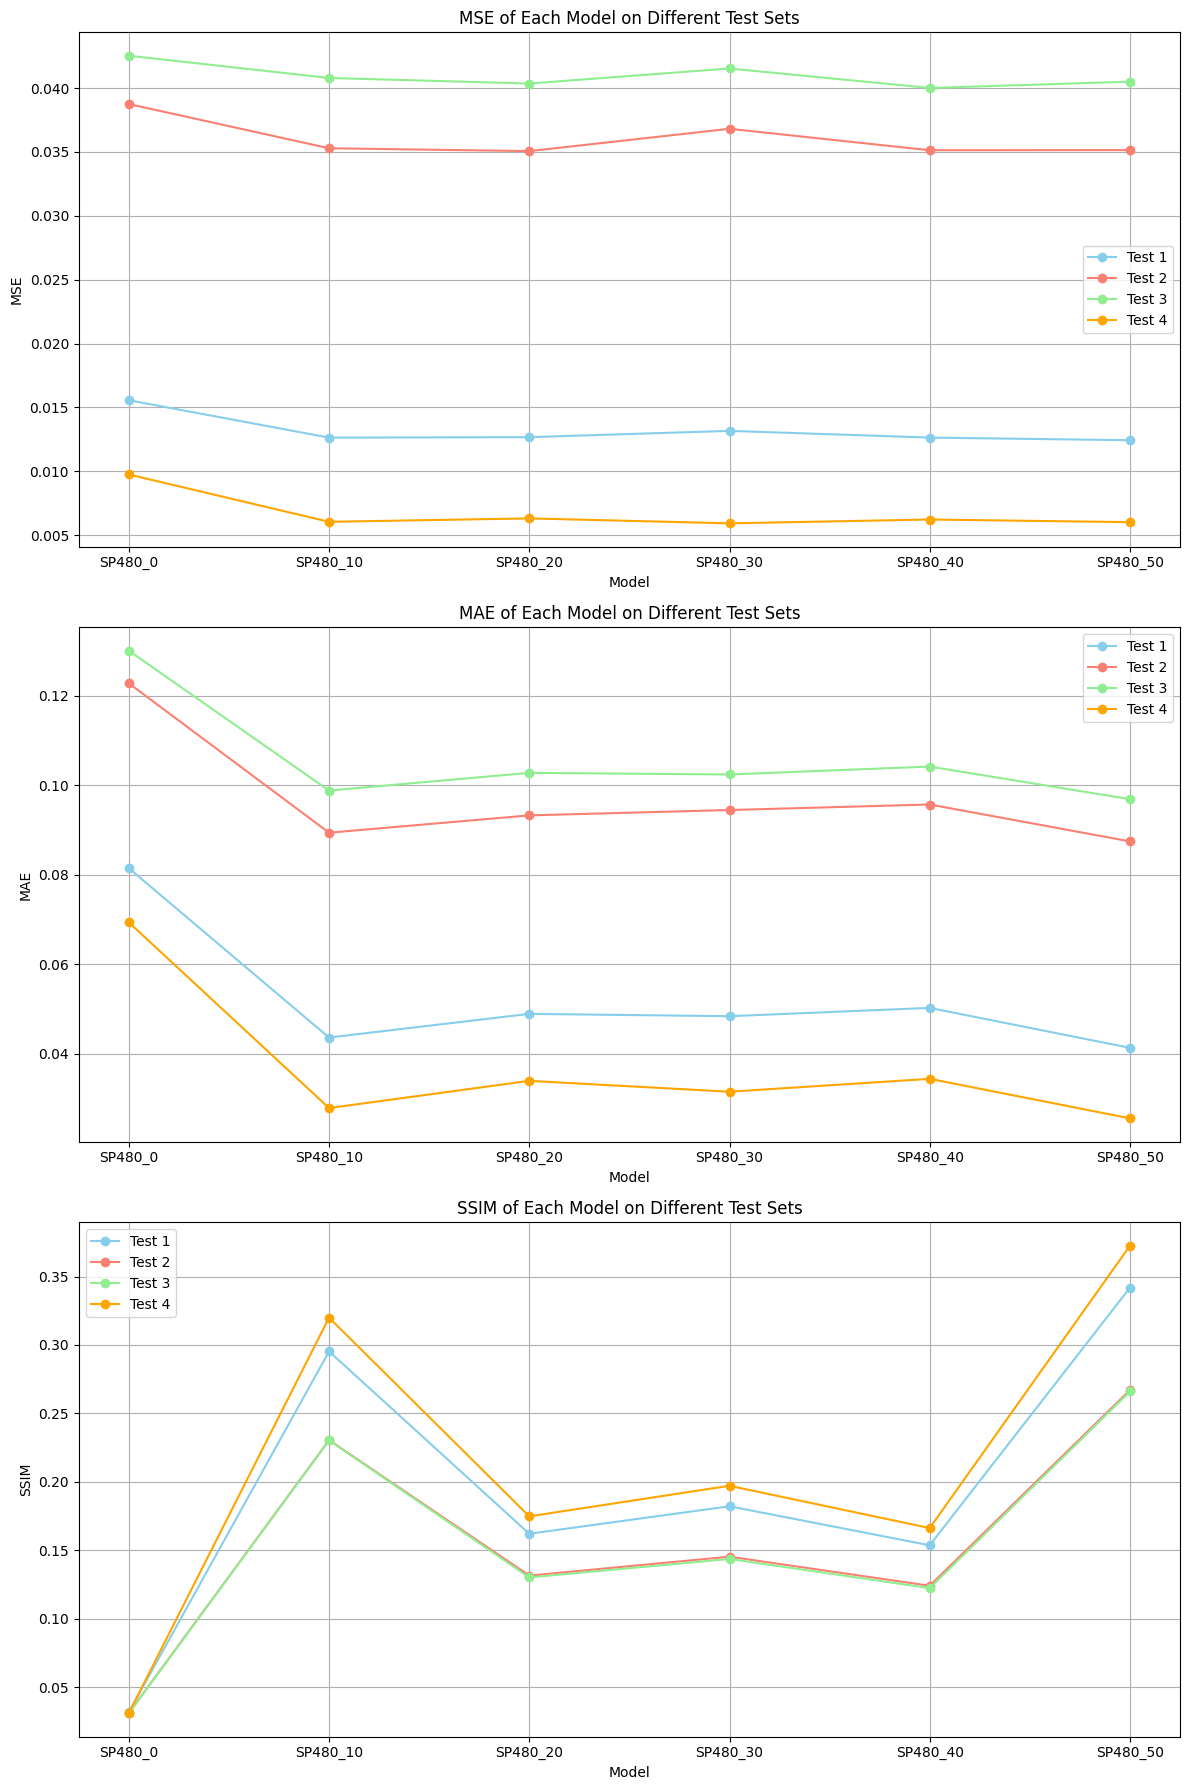

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 `results` 是形状为 (6, 4, 3) 的数组，其中:
# - `results[i, j, 0]` 是模型 `i` 在测试集 `j` 上的 MSE
# - `results[i, j, 1]` 是模型 `i` 在测试集 `j` 上的 MAE
# - `results[i, j, 2]` 是模型 `i` 在测试集 `j` 上的 SSIM

# 模型和测试集的标签
model_labels = [f"SP480_{i*10}" for i in range(6)]  # 模型名称: SP480_0, SP480_10, SP480_20, etc.
test_labels = [f"Test {i+1}" for i in range(4)]

# 绘制 MSE, MAE, SSIM 的图表，每个图表展示各模型在不同测试集上的指标
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
metrics = ["MSE", "MAE", "SSIM"]
colors = ["skyblue", "salmon", "lightgreen", "orange"]  # 每个测试集的颜色

for i, metric in enumerate(metrics):
    ax = axes[i]
    for test_idx in range(len(test_labels)):
        ax.plot(model_labels, results[:, test_idx, i], label=test_labels[test_idx], marker='o', color=colors[test_idx])
    ax.set_title(f"{metric} of Each Model on Different Test Sets")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


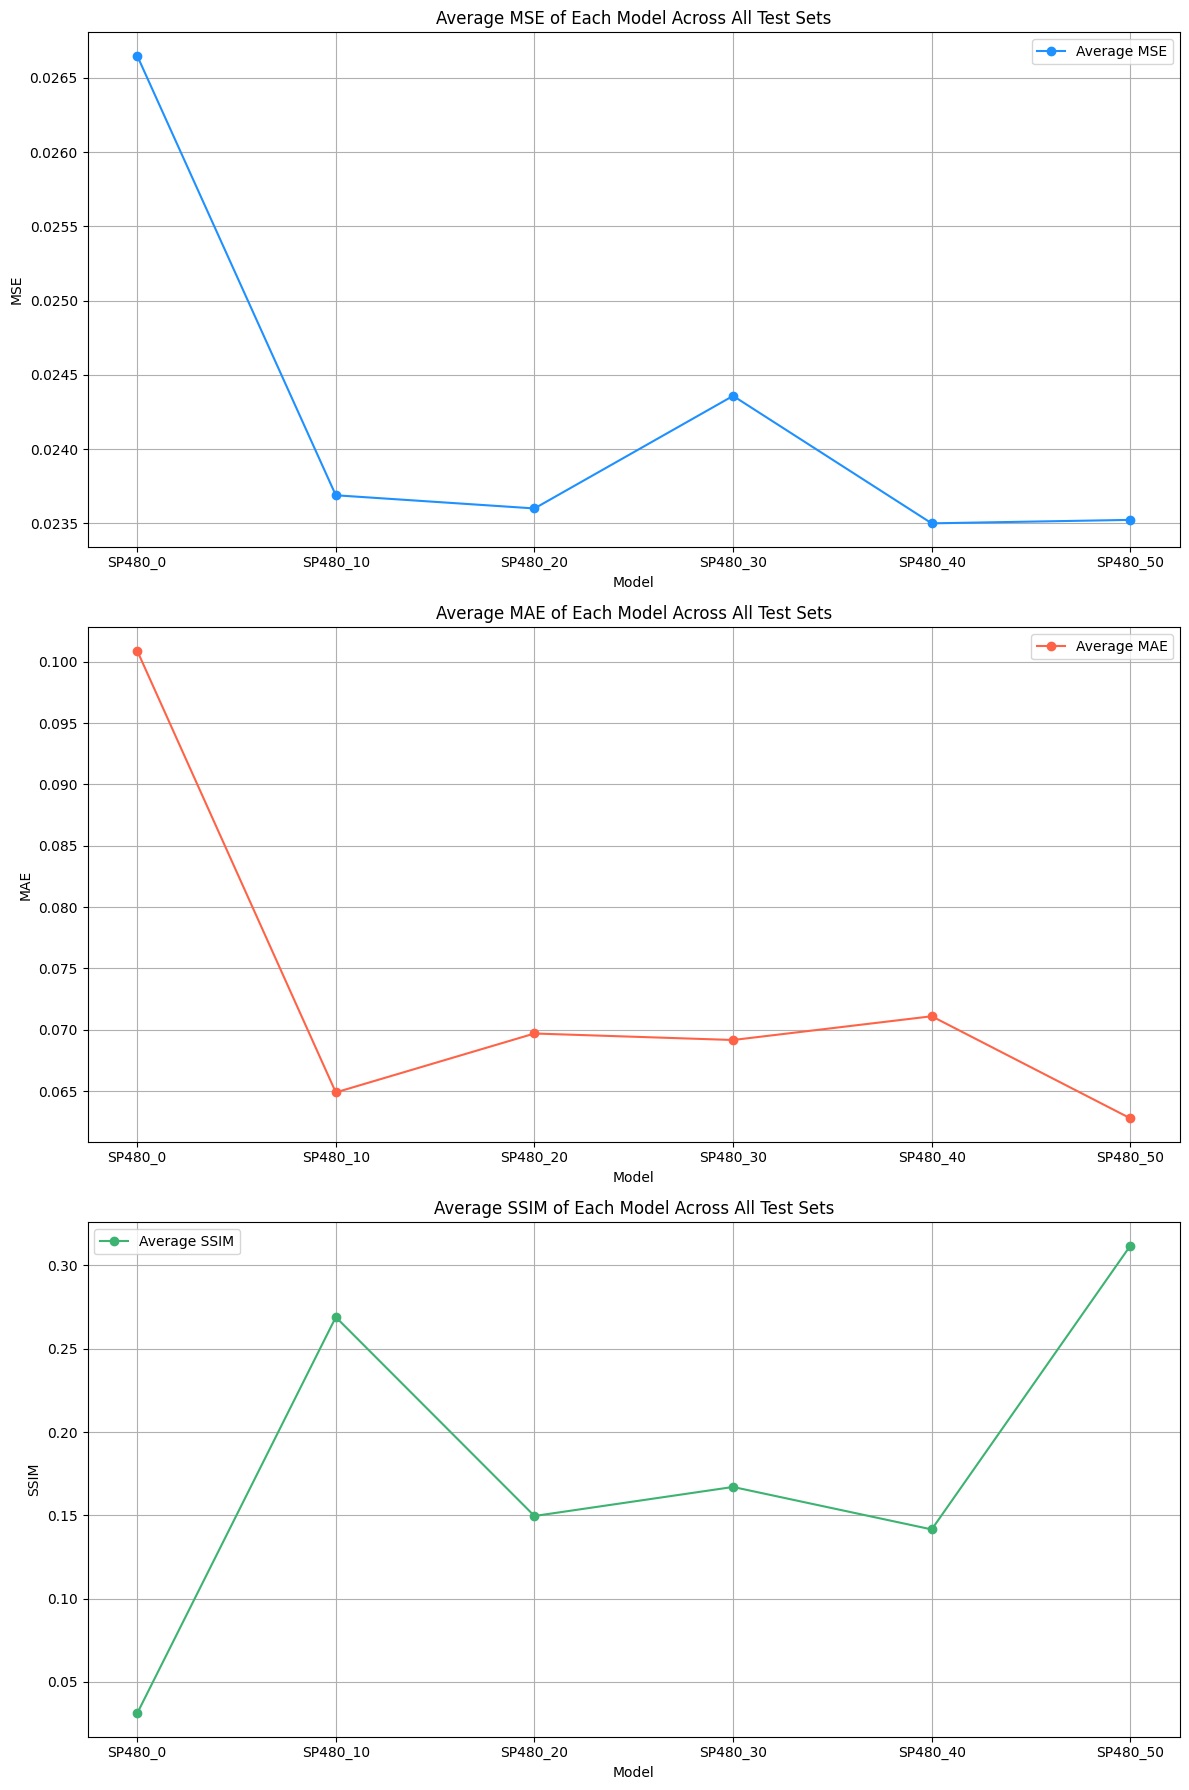

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 `results` 是形状为 (6, 4, 3) 的数组，其中:
# - `results[i, j, 0]` 是模型 `i` 在测试集 `j` 上的 MSE
# - `results[i, j, 1]` 是模型 `i` 在测试集 `j` 上的 MAE
# - `results[i, j, 2]` 是模型 `i` 在测试集 `j` 上的 SSIM

# 模型的标签
model_labels = [f"SP480_{i*10}" for i in range(6)]  # 模型名称: SP480_0, SP480_10, SP480_20, etc.

# 计算每个模型在四个测试集上的平均 MSE, MAE 和 SSIM
average_results = np.mean(results, axis=1)  # 计算沿测试集维度的平均值, 得到 (6, 3) 的数组

# 绘制 MSE, MAE, SSIM 的图表，展示各模型的平均指标
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
metrics = ["MSE", "MAE", "SSIM"]
colors = ["dodgerblue", "tomato", "mediumseagreen"]  # 每个指标的颜色

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(model_labels, average_results[:, i], label=f"Average {metric}", marker='o', color=colors[i])
    ax.set_title(f"Average {metric} of Each Model Across All Test Sets")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


# SP480_50
根据图表中的结果，可以选择一个在 MSE、MAE、和 SSIM 综合表现最优的模型。以下是选择模型时的考虑：  

MSE 和 MAE 越低越好：这两个指标越低，模型的预测误差越小。  
SSIM 越高越好：结构相似性 (SSIM) 越高，模型的预测图像与真实图像的结构越接近。  
从图表中观察：  
  
SP480_10 和 SP480_50 的 MSE 和 MAE 都较低。  
SP480_50 的 SSIM 最高，这意味着它在保持图像结构上表现最好。  
综合来看，SP480_50 在所有三个指标上表现出较好的平衡。因此，建议选择 SP480_50 作为最终模型，因为它在 SSIM 上表现最好，同时在 MSE 和 MAE 上也维持在低水平。  

1/1 [==============================] - 0s 36ms/step


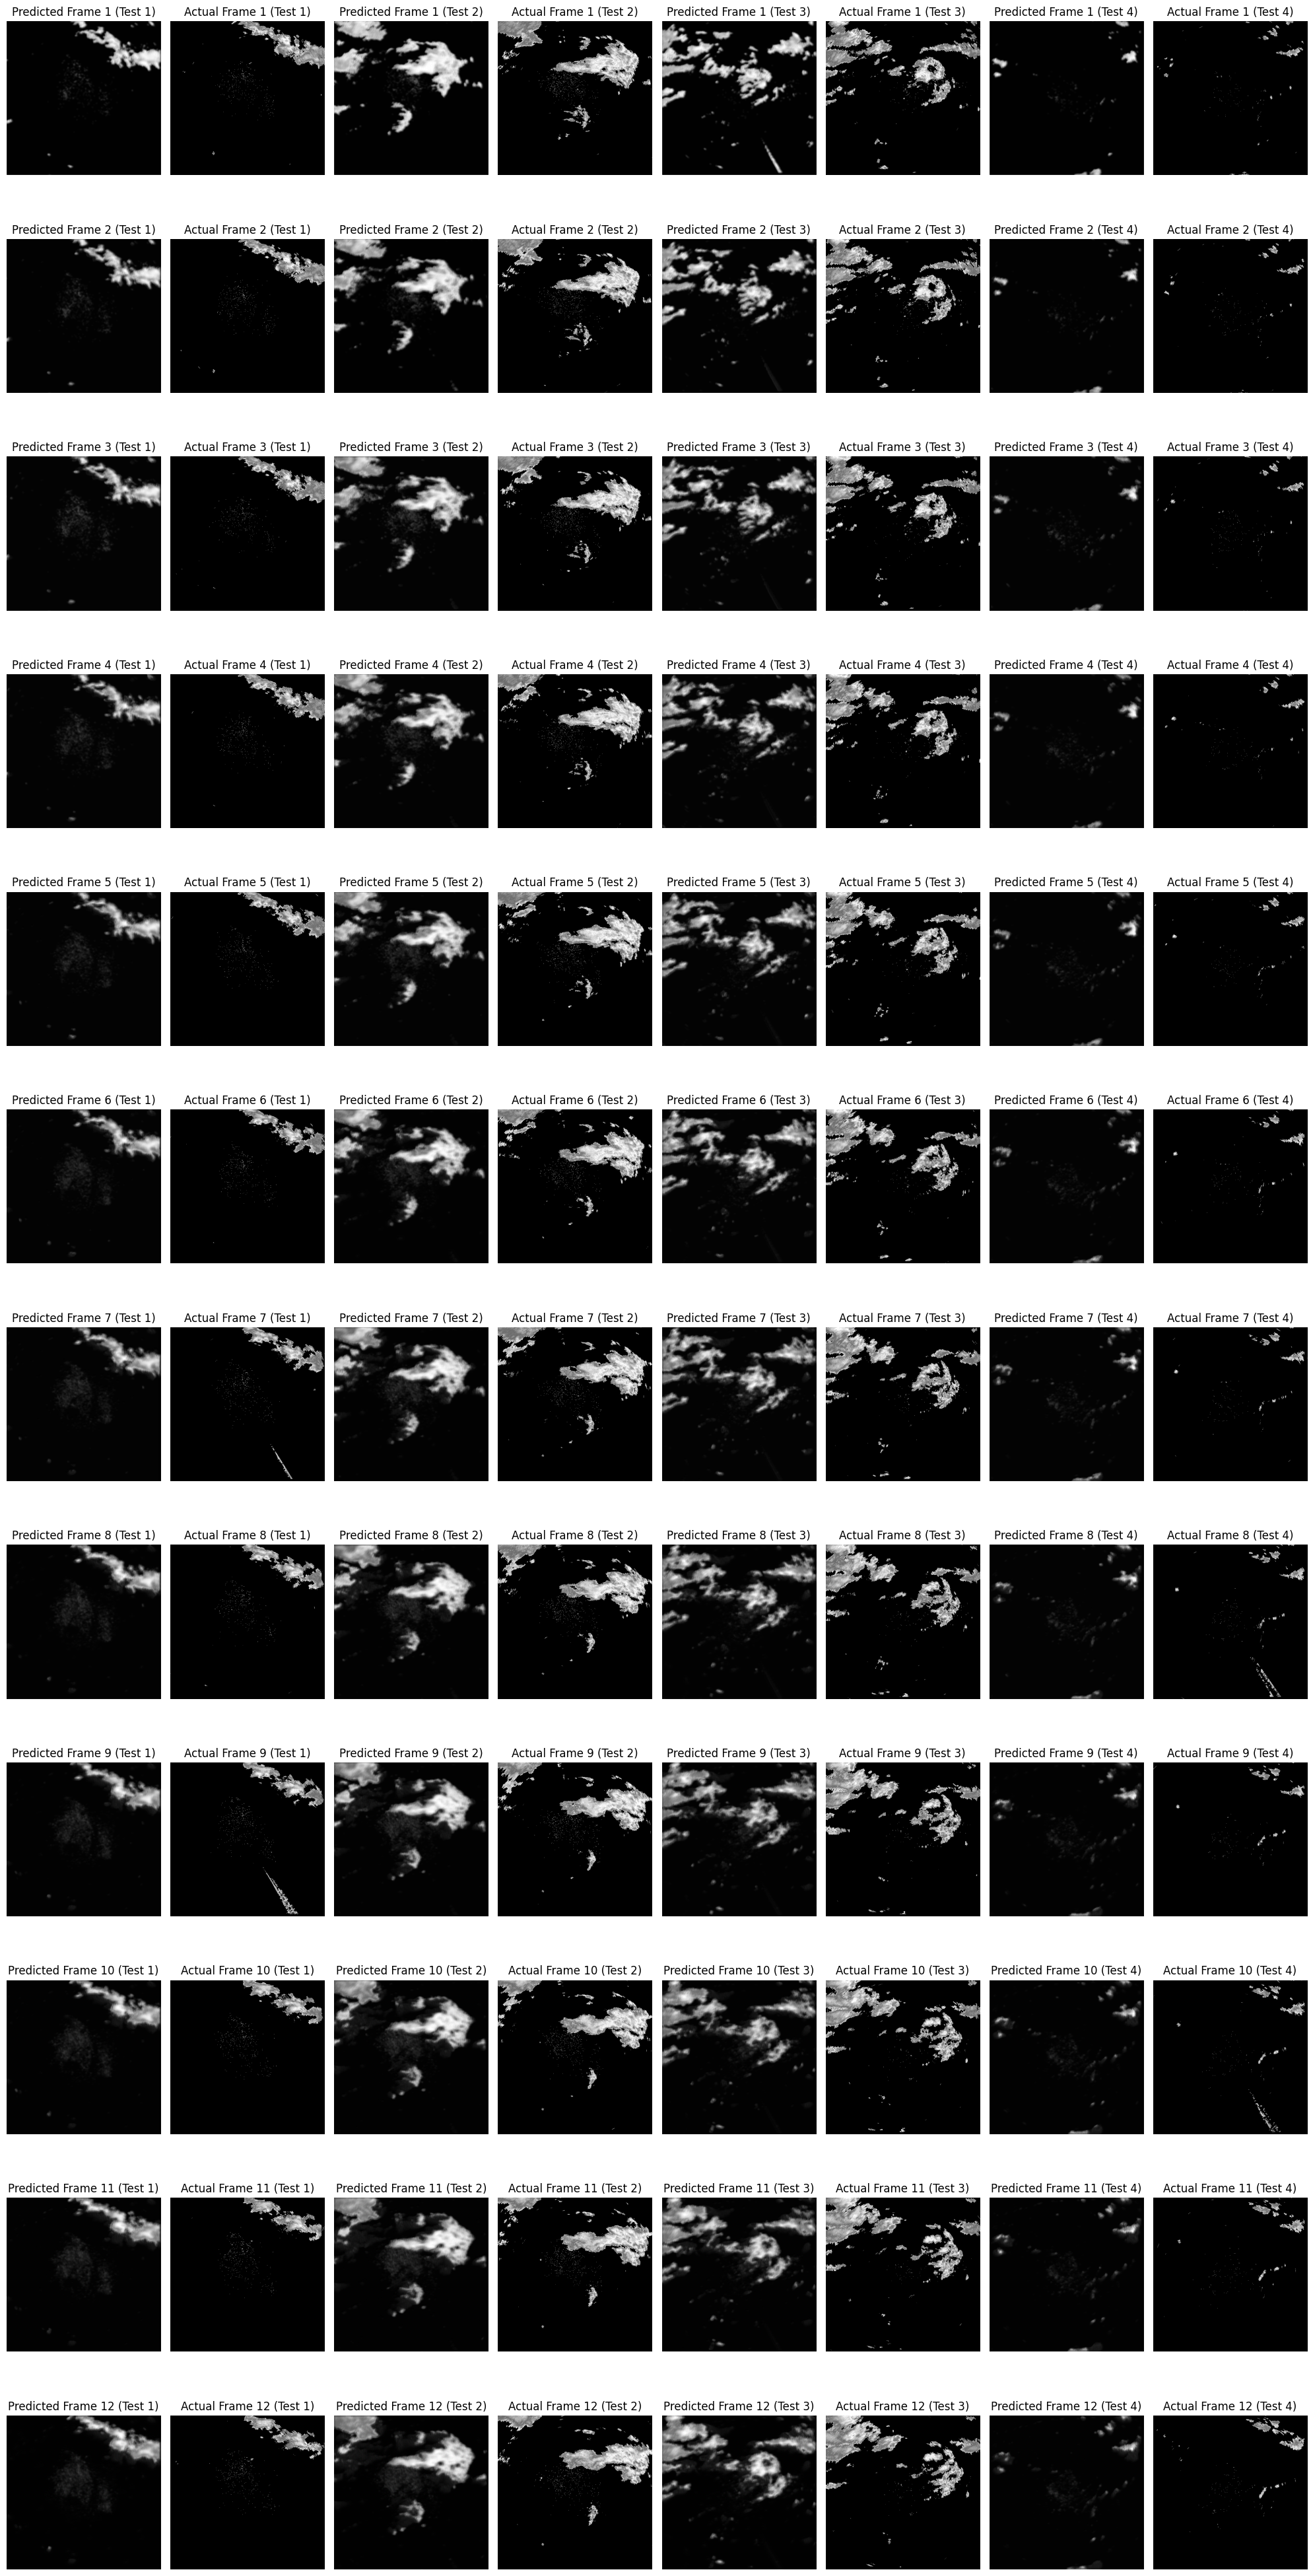

MSE: [0.012429531588437173, 0.03514650914069655, 0.04050363944045675, 0.006013567761938594]
MAE: [0.04127383558232077, 0.08743742500753109, 0.09687542902268054, 0.025502380543556746]
SSIM: [0.3418554334732669, 0.2670700118481464, 0.2660333737619249, 0.37253902846747705]


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model

# 加载模型
model_path = './Models/Add/SP480_50.h5'  # 替换为您希望测试的模型路径
model = load_model(model_path)

# 设置参数
time_steps = 12
pred_steps = 12
test_folders = ['./testData/1', './testData/2', './testData/3', './testData/4']

# 准备存储结果的字典
results = {
    "mse": [],
    "mae": [],
    "ssim": []
}

# 准备显示的对比结果图像
fig, axs = plt.subplots(12, 8, figsize=(20, 40))

# 遍历测试数据文件夹
for folder_index, test_folder in enumerate(test_folders):
    # 加载测试图像数据并预处理
    test_images = []
    image_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.png')])
    for file in image_files:
        img = cv2.imread(os.path.join(test_folder, file), cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (480, 480), interpolation=cv2.INTER_AREA)
        normalized_img = resized_img / 255.0  # 归一化
        test_images.append(normalized_img)

    # 转换成 NumPy 数组并添加通道维度
    test_images = np.array(test_images)[..., np.newaxis]  # 形状: (24, 480, 480, 1)

    # 准备测试输入数据
    X_test = np.array([test_images[i:i + time_steps] for i in range(len(test_images) - time_steps - pred_steps + 1)])
    y_actual = np.array([test_images[i + time_steps:i + time_steps + pred_steps] for i in range(len(test_images) - time_steps - pred_steps + 1)])

    # 使用模型进行预测
    y_pred = model.predict(X_test)

    # 计算 MSE, MAE 和 SSIM
    mse = mean_squared_error(y_actual.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_actual.flatten(), y_pred.flatten())
    ssim_scores = [ssim(y_actual[0, i, :, :, 0], y_pred[0, i, :, :, 0], data_range=1.0) for i in range(pred_steps)]
    mean_ssim = np.mean(ssim_scores)

    # 存储结果
    results["mse"].append(mse)
    results["mae"].append(mae)
    results["ssim"].append(mean_ssim)

    # 绘制预测和实际帧对比
    for frame_index in range(12):  # 每行显示 12 帧的对比
        # 预测帧在偶数列
        axs[frame_index, folder_index * 2].imshow(y_pred[0, frame_index, :, :, 0], cmap='gray')
        axs[frame_index, folder_index * 2].set_title(f"Predicted Frame {frame_index+1} (Test {folder_index+1})")
        axs[frame_index, folder_index * 2].axis('off')
        
        # 实际帧在奇数列
        axs[frame_index, folder_index * 2 + 1].imshow(y_actual[0, frame_index, :, :, 0], cmap='gray')
        axs[frame_index, folder_index * 2 + 1].set_title(f"Actual Frame {frame_index+1} (Test {folder_index+1})")
        axs[frame_index, folder_index * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

# 输出结果
print("MSE:", results["mse"])
print("MAE:", results["mae"])
print("SSIM:", results["ssim"])


In [8]:
# Define maximum error thresholds (adjust based on data characteristics)
max_mse = 0.1
max_mae = 0.1

# Calculate accuracy
accuracy_results = {
    "mse_accuracy": [(1 - min(mse / max_mse, 1)) * 100 for mse in results["mse"]],
    "mae_accuracy": [(1 - min(mae / max_mae, 1)) * 100 for mae in results["mae"]],
    "ssim_accuracy": [ssim * 100 for ssim in results["ssim"]]
}

# Print accuracy for each test set
for i, test_folder in enumerate(test_folders):
    print(f"\nAccuracy for Test Set {i+1}:")
    print(f"MSE Accuracy: {accuracy_results['mse_accuracy'][i]:.2f}%")
    print(f"MAE Accuracy: {accuracy_results['mae_accuracy'][i]:.2f}%")
    print(f"SSIM Accuracy: {accuracy_results['ssim_accuracy'][i]:.2f}%")

# Calculate overall average accuracy
overall_mse_accuracy = np.mean(accuracy_results["mse_accuracy"])
overall_mae_accuracy = np.mean(accuracy_results["mae_accuracy"])
overall_ssim_accuracy = np.mean(accuracy_results["ssim_accuracy"])

print("\nOverall Average Accuracy:")
print(f"Average MSE Accuracy: {overall_mse_accuracy:.2f}%")
print(f"Average MAE Accuracy: {overall_mae_accuracy:.2f}%")
print(f"Average SSIM Accuracy: {overall_ssim_accuracy:.2f}%")



Accuracy for Test Set 1:
MSE Accuracy: 87.57%
MAE Accuracy: 58.73%
SSIM Accuracy: 34.19%

Accuracy for Test Set 2:
MSE Accuracy: 64.85%
MAE Accuracy: 12.56%
SSIM Accuracy: 26.71%

Accuracy for Test Set 3:
MSE Accuracy: 59.50%
MAE Accuracy: 3.12%
SSIM Accuracy: 26.60%

Accuracy for Test Set 4:
MSE Accuracy: 93.99%
MAE Accuracy: 74.50%
SSIM Accuracy: 37.25%

Overall Average Accuracy:
Average MSE Accuracy: 76.48%
Average MAE Accuracy: 37.23%
Average SSIM Accuracy: 31.19%


# Accuracy Rate: 76.48% !!!!